In [1]:
import time
import ROOT
import numpy as np
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from root_pandas import read_root
from matplotlib import rc
from numpy import inf

rc('text', usetex=True)

Welcome to JupyROOT 6.15/01


In [2]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut)
    return cutDataframe

In [3]:
def getJetData(inputFiles):
    
    cols = []
    scalar = []
    scalar.append('evid')
    scalar.append('xsec')
    scalar.append('ntrials')    
    scalar.append('x')
    scalar.append('y')
    scalar.append('Q2')
    scalar.append('W2')


    cols.append('n_total')
    cols.append('jet_eta')
    cols.append('jet_theta')
    cols.append('jet_p')
    cols.append('jet_pt')
    cols.append('jet_qt')
    cols.append('jet_qt_breit')
    cols.append('jet_z')
    
    lists = scalar
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists+cols,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [4]:
def getData(inputFiles):
    
    cols = []
    scalar = []
    scalar.append('evid')
    scalar.append('xsec')
    scalar.append('ntrials')    
    scalar.append('x')
    scalar.append('y')
    scalar.append('Q2')
    scalar.append('e_eta')
    scalar.append('e_theta')
    scalar.append('e_p')
    scalar.append('e_pt')

    scalar.append('quark_eta')
    scalar.append('quark_theta')
    scalar.append('quark_p')
    scalar.append('quark_pt')
    
    
    lists = scalar
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists+cols,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [65]:
def applyEventCuts(df):
    temp = df
    temp = applyCut(temp, '0.1 < y < 0.85', '0.1 < y < 0.85')
    temp = applyCut(temp, 'Q2>25', 'Q2>25')
    #temp = applyCut(temp, 'x > 0.05', 'x>0.05')
    temp.eval('logQ2= log(Q2)/2.3025850', inplace=True)
    temp.eval('logx= log(x)/2.3025850', inplace=True)
    return temp

def applyJetCuts(df):
    temp = df
    temp.eval('jet_qtnorm= jet_qt_breit/sqrt(Q2)', inplace=True)
    temp.eval('jet_qtnormjetpt= jet_qt_breit/sqrt(jet_pt)', inplace=True)
    temp = applyCut(temp, ' jet_z>0.25', 'jet_z>0.25')
    temp = applyCut(temp, ' jet_eta<0', 'jet eta <0')
    df = applyCut(df, 'n_total>1', ' n>1')
    return temp

In [6]:
df = getData(['NC_10_275.root'])
xsec = np.mean(df['xsec'])
xsec = xsec*1e9
print 'xsection %2.2f [pb]' %(xsec)
accepted = df.shape[0]
print 'accepted events' , accepted
to_cross_section = xsec/(1.0*accepted)

df = applyEventCuts(df)
print 'Accepted cross-section: %2.0f [pb]'%(df.shape[0]*to_cross_section)

##Total cross-section: 
## in units of fb:
lumi = 100 # in units of fb-1. 
integrated_rate    = 1000*lumi*xsec #multiply by 1000 and then 100 to get integrated yield for 100 fb-1
print 'Integrated rate %2.3f [M]' %(integrated_rate/1e6)


Processed NC_10_275.root in 0.6 seconds
xsection 17649.20 [pb]
accepted events 250000
0.1 < y < 0.85 133361  fraction kept: 53.3
Q2>25 132535  fraction kept: 99.4
Accepted cross-section: 9357 [pb]
Integrated rate 1764.920 [M]


## Get Jet data apply selection

In [63]:
df_jet      = getJetData(['NC_10_275_Breit.root'])
df_jet = applyEventCuts(df_jet)


Processed NC_10_275_Breit.root in 12.5 seconds
0.1 < y < 0.85 1708934  fraction kept: 75.4
Q2>25 1708934  fraction kept: 100.0


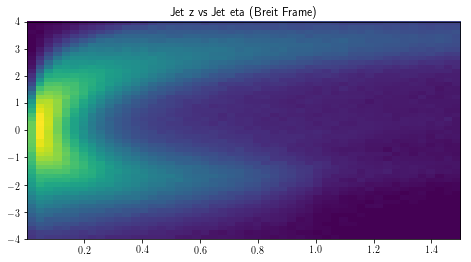

In [64]:
import matplotlib.colors as mcolors

fig, axs = plt.subplots(ncols=1, sharey=True, figsize=(7, 4))
fig.subplots_adjust(hspace=0.5, left=0.07, right=0.93)
ax = axs
hb = ax.hist2d(df_jet.query('jet_z<1.5 and abs(jet_eta)<4.0')['jet_z'], df_jet.query('jet_z<1.5 and abs(jet_eta)<4.0')['jet_eta'], norm=mcolors.PowerNorm(0.5),bins=50)

ax.set_title('Jet z vs Jet eta (Breit Frame)')


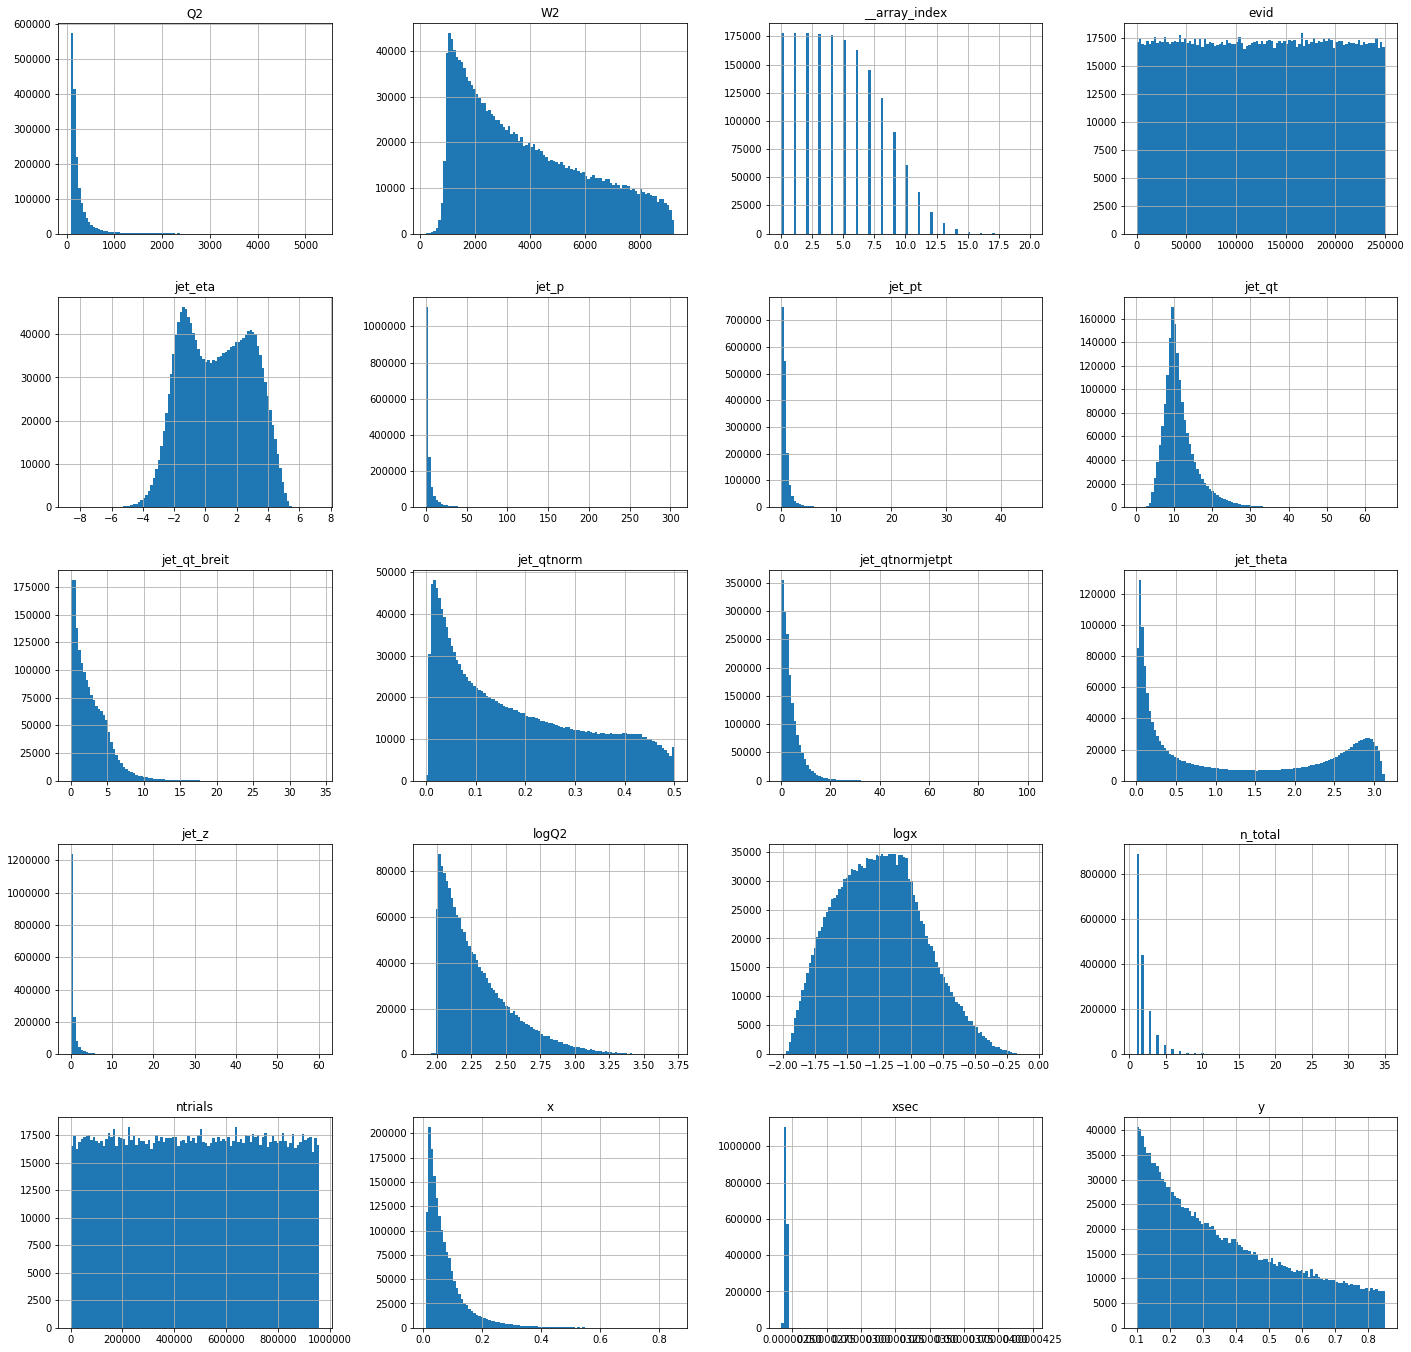

In [37]:
rc('text', usetex=False)
df_jet.hist(figsize=(24,24),bins=100)
plt.show()

# plot the z distribution of jets in current and target framengtation

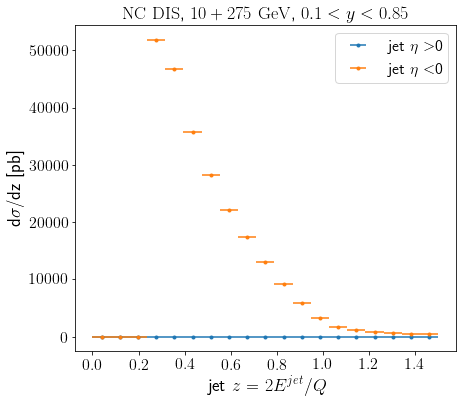

In [67]:
rc('text', usetex=True)

fig, ax1 = plt.subplots(figsize=(15,6))

##Electron distribution
plt.subplot(121)
y, x  = np.histogram(df_jet.query('jet_eta>0')['jet_z'],bins=np.linspace(0,1.5,20))
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y*to_cross_section
y = y/(xerr*2.0)
plt.errorbar(x,y,  xerr = xerr, fmt='.',ls='none',label=r'jet $\eta>$0')

y, x  = np.histogram(df_jet.query('jet_eta<0')['jet_z'],bins=np.linspace(0,1.5,20))
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y*to_cross_section
y = y/(xerr*2.0)
plt.errorbar(x,y,  xerr = xerr, fmt='.',ls='none',label=r'jet $\eta<$0')

plt.legend(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('jet $z$ = $2E^{jet}/Q$',fontsize=18)
plt.ylabel(r'd$\sigma$/dz [pb]',fontsize=18)
plt.title('$\mathrm{NC}\ \mathrm{DIS}$, $10+275$ $\mathrm{GeV}$, $0.1<y<0.85$', fontsize=18)

## Apply jet cuts

In [66]:
df_jet = applyJetCuts(df_jet)

jet_z>0.25 900710  fraction kept: 52.7
jet eta <0 269448  fraction kept: 29.9
 n>1 821007  fraction kept: 48.0


In [ ]:
## z distribution:

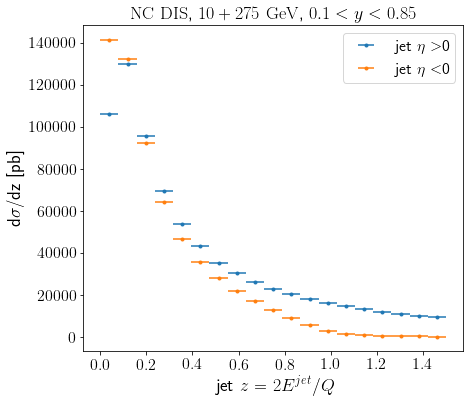

In [36]:
rc('text', usetex=True)

fig, ax1 = plt.subplots(figsize=(15,6))

##Electron distribution
plt.subplot(121)
y, x  = np.histogram(df_jet.query('jet_eta>0')['jet_z'],bins=np.linspace(0,1.5,20))
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y*to_cross_section
y = y/(xerr*2.0)
plt.errorbar(x,y,  xerr = xerr, fmt='.',ls='none',label=r'jet $\eta>$0')

y, x  = np.histogram(df_jet.query('jet_eta<0')['jet_z'],bins=np.linspace(0,1.5,20))
xerr = (x[1:] - x[:-1])/2.0
x = (x[1:]+x[:-1])/2
y = y*to_cross_section
y = y/(xerr*2.0)
plt.errorbar(x,y,  xerr = xerr, fmt='.',ls='none',label=r'jet $\eta<$0')

plt.legend(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('jet $z$ = $2E^{jet}/Q$',fontsize=18)
plt.ylabel(r'd$\sigma$/dz [pb]',fontsize=18)
plt.title('$\mathrm{NC}\ \mathrm{DIS}$, $10+275$ $\mathrm{GeV}$, $0.1<y<0.85$', fontsize=18)


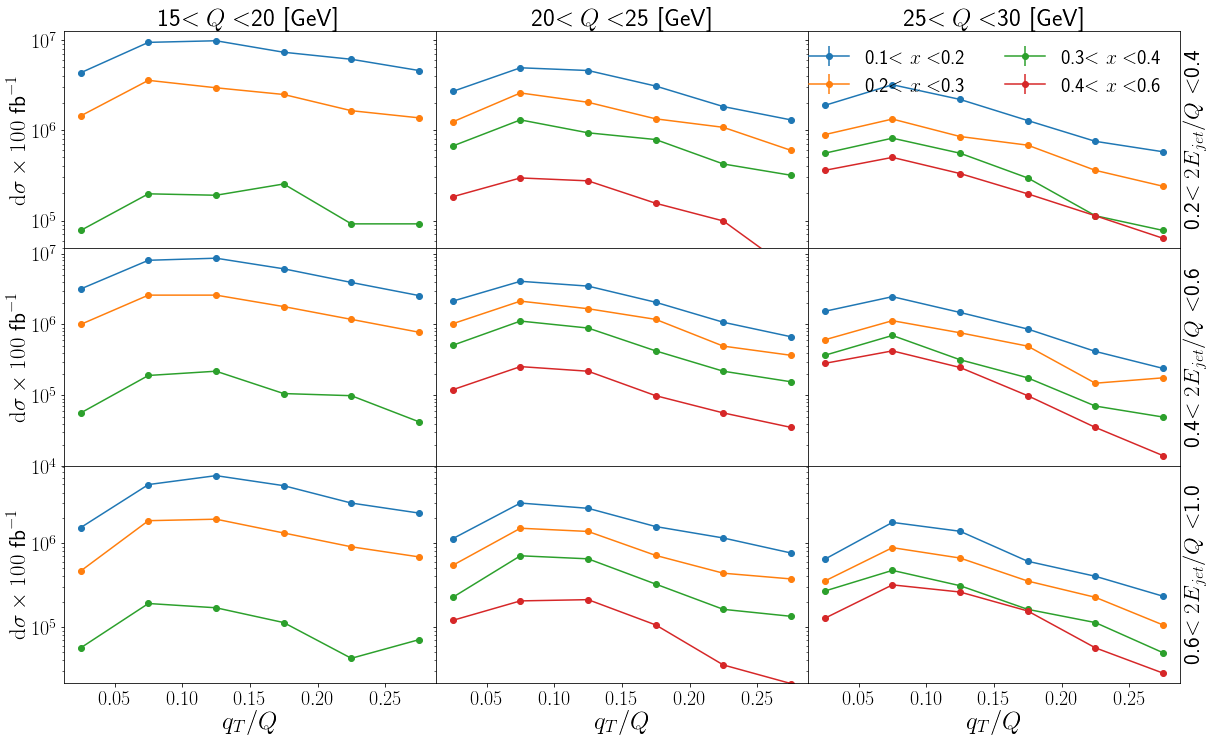

In [162]:
from matplotlib import rc
rc('text', usetex=True)


fig, axs = plt.subplots(3, 3, sharex=True, sharey='row', figsize=(20,12),gridspec_kw={'hspace':0,'wspace':0})

for counter,edges in enumerate([(15,20),(20,25),(25,30)]):
    df_Q2cut = df_jet.query('sqrt(Q2)> %2.2f and sqrt(Q2)<%2.2f'%(edges[0],edges[1]))
    axs[0,counter].set_title(r' %2.0f$<Q<$%2.0f [GeV]'%(edges[0],edges[1]), fontsize=25)
    
    for zcounter,zedges in enumerate([(0.2,0.4), (0.4,0.6),(0.6,1.0)]):
        df_zcut = df_Q2cut.query('jet_z> %2.2f and jet_z<%2.2f'%(zedges[0],zedges[1]))
        axs[zcounter,2].yaxis.set_label_position("right")
        axs[zcounter,2].yaxis.set_label_text(' %2.1f$<2E_{jet}/Q<$%2.1f'%(zedges[0],zedges[1]),fontsize=23)
        #for xcounter,xedges in enumerate([(0.1,0.15), (0.15,0.2),(0.2,0.25),(0.25,0.30),(0.30,0.35),(0.35,0.40)]):
        for xcounter,xedges in enumerate([(0.1,0.2), (0.2,0.3),(0.3,0.4),(0.4,0.6)]):
            df_xcut = df_zcut.query('x> %2.2f and x<%2.2f'%(xedges[0],xedges[1]))
            y, x  = np.histogram(df_xcut['jet_qtnorm'],bins=6,range=(0,0.3))
            x = (x[1:]+x[:-1])/2
            y = y*to_cross_section
            y = y*1000*lumi
            erry = np.sqrt(y)
            label = '%2.1f$<x<$%2.1f'%(xedges[0],xedges[1])
            row = counter%3
            axs[zcounter,counter].errorbar(x,y,yerr=erry, fmt='-o',label=label)
            axs[zcounter,counter].semilogy()
            axs[zcounter,counter].tick_params('both',labelsize=20)

    
axs[2,0].xaxis.set_label_text(r'$q_{T}/Q$', fontsize=25)
axs[2,1].xaxis.set_label_text(r'$q_{T}/Q$', fontsize=25)
axs[2,2].xaxis.set_label_text(r'$q_{T}/Q$', fontsize=25)

axs[0,0].yaxis.set_label_text(r'$\mathrm{d \sigma}\times 100 $ fb^{-1}', fontsize=23)
axs[1,0].yaxis.set_label_text(r'$\mathrm{d \sigma}\times 100 $ fb^{-1}', fontsize=23)
axs[2,0].yaxis.set_label_text(r'$\mathrm{d \sigma}\times 100 $ fb^{-1}', fontsize=23)

axs[0,2].legend(fontsize=20,frameon=False,ncol=2)





axs[0,0].tick_params('both',labelsize=20)
#axs[0,0].xticks(fontsize=20)

    #axs[counter].text(0.1,6, , fontsize=20)
    #axs[counter].text(0.1,8, '$\sqrt{s} = 89 \, \mathrm{GeV}$ \n $0.1 < y < 0.85$ \n $p_T^{jet} > 4 \, \mathrm{GeV/c}$', fontsize=20)
    #plt.legend(prop={'size': 20}, frameon=False, loc='best')
    #axs[counter].text(0.07,10, r' $ %2.0f< p_{\mathrm{T}}^{e} < %2.0f$'%(edges[0],edges[1]) + '$\ \mathrm{ GeV}$ \n' +
                   #   r'$\langle x \rangle = %2.2f, \langle Q^{2} \rangle = %2.0f \ \mathrm{GeV}^{2}$'%(df_cut['x'].mean(), df_cut['Q2'].mean()), fontsize=25)

#axs[1].set_title(r'NC\ DIS \ $10+275$ \ $\mathrm{GeV}$, 100 $\mathrm{fb}^{-1}$ , $0.1<y<0.85$, $Q^{2}>25$ $\mathrm{GeV}^{2}$',fontsize=25)  

plt.savefig('NC_LeptonJetqt.png', bbox_inches='tight')
plt.savefig('NC_LeptonJetqt.pdf', bbox_inches='tight')